In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import collections
from scipy import stats

In [2]:
df = pd.read_csv('sim_trace.csv')
# como otimizar a quantidade de recebedores alocados.
# 1 - arrumar as escalas do gráfico
# 2 - rodar o numero médio de saltos tempo(eixo x)
# 3 - Enviar imagens whats explicando a alocação por tempo e a melhora da latecia pela centralidade em comparação com a aleatória
# 4 - Trocar a alocação por tempo por alocação por demanda (checagem de melhora na latencia a cada nova alocação)
# Isto é, se há a necessidade de alocar mais recebedores?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              77 non-null     int64  
 1   type            77 non-null     object 
 2   app             77 non-null     int64  
 3   module          77 non-null     object 
 4   message         77 non-null     object 
 5   DES.src         77 non-null     int64  
 6   DES.dst         77 non-null     int64  
 7   TOPO.src        77 non-null     int64  
 8   TOPO.dst        77 non-null     int64  
 9   module.src      77 non-null     object 
 10  service         77 non-null     float64
 11  time_in         77 non-null     float64
 12  time_out        77 non-null     float64
 13  time_emit       77 non-null     float64
 14  time_reception  77 non-null     float64
dtypes: float64(5), int64(6), object(4)
memory usage: 9.1+ KB


In [4]:
df["time_latency"] = df["time_reception"] - df["time_emit"]
df["time_wait"] = df["time_in"] - df["time_reception"]  
df["time_service"] = df["time_out"] - df["time_in"]
df["time_response"] = df["time_out"] - df["time_reception"]
df["time_total_response"] = df["time_response"] + df["time_latency"]

In [5]:
# convert index to date type in order to use resample and agreegate functions of pandas
df["date"]=df.time_in.astype('datetime64[s]')
df.index = df.date

In [6]:
df.head()

,id,type,app,module,message,DES.src,DES.dst,TOPO.src,TOPO.dst,module.src,...,time_in,time_out,time_emit,time_reception,time_latency,time_wait,time_service,time_response,time_total_response,date
date,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:01:41,1,COMP_M,0,0_01,M.USER.APP.0,0,8,1,0,None,...,101.00002,101.15002,100.0,101.00002,1.00002,0.00,0.15,0.15,1.15002,1970-01-01 00:01:41
1970-01-01 00:01:41,4,COMP_M,0,0_01,M.USER.APP.0,3,8,4,0,None,...,101.15002,101.30002,100.0,101.00002,1.00002,0.15,0.15,0.30,1.30002,1970-01-01 00:01:41
1970-01-01 00:01:42,3,COMP_M,0,0_01,M.USER.APP.0,2,8,3,0,None,...,102.00004,102.15004,100.0,102.00004,2.00004,0.00,0.15,0.15,2.15004,1970-01-01 00:01:42
1970-01-01 00:01:42,5,COMP_M,0,0_01,M.USER.APP.0,4,8,5,0,None,...,102.15004,102.30004,100.0,102.00004,2.00004,0.15,0.15,0.30,2.30004,1970-01-01 00:01:42
1970-01-01 00:01:42,7,COMP_M,0,0_01,M.USER.APP.0,6,8,7,0,None,...,102.30004,102.45004,100.0,102.00004,2.00004,0.30,0.15,0.45,2.45004,1970-01-01 00:01:42


In [7]:
df_resample = df.resample('100s').agg(dict(time_latency='mean'))

In [8]:
df_resample.shape

(11, 1)

In [9]:
df_resample

,time_latency
date,
1970-01-01 00:01:40,2.14290
1970-01-01 00:03:20,2.14290
1970-01-01 00:05:00,1.71432
1970-01-01 00:06:40,1.71432
1970-01-01 00:08:20,1.14288
1970-01-01 00:10:00,1.14288
1970-01-01 00:11:40,0.85716
1970-01-01 00:13:20,0.85716
1970-01-01 00:15:00,0.71430


In [10]:
timeLatency = df_resample.time_latency.values

In [11]:
timeLatency

array([2.1429 , 2.1429 , 1.71432, 1.71432, 1.14288, 1.14288, 0.85716,
       0.85716, 0.7143 , 0.7143 , 0.7143 ])

In [12]:
df_emit = df.time_emit.unique()

In [13]:
df_emit

array([ 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
       1000., 1100.])

In [14]:
ticks = df_emit

In [15]:
ticks

array([ 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
       1000., 1100.])

Text(0, 0.5, 'Latency time (ms)')

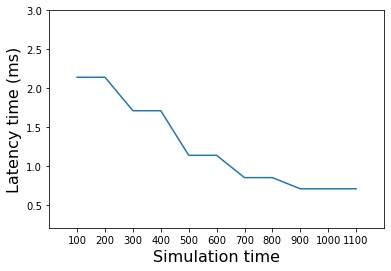

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(ticks, timeLatency, '-')
ax1.set_xticks(ticks)
ax1.set_ylim(timeLatency.min()-0.5,3)#timeLatency.max()+0.5)
ax1.set_xlim(ticks.min()-100, ticks.max()+100)# (0, 1200) or ticks.min(), ticks.max()
ax1.set_xlabel("Simulation time", fontsize=16)
ax1.set_ylabel("Latency time (ms)", fontsize=16)

# Latency

In [17]:
df_resample = df.resample('100s').agg(dict(time_latency='mean'))

In [18]:
df_resample.shape

(11, 1)

In [19]:
timeLatency = df_resample.time_latency.values

In [20]:
ticks = df_emit

Text(0, 0.5, 'Latency time')

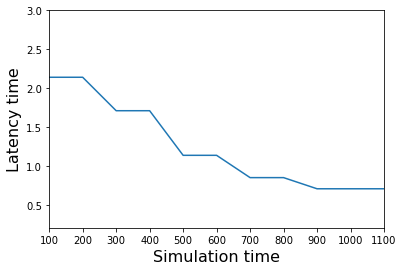

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(ticks, timeLatency, '-')
ax1.set_xticks(ticks)
ax1.set_ylim(timeLatency.min()-0.5,3)#timeLatency.max()+0.5)
ax1.set_xlim(ticks.min(), ticks.max())
ax1.set_xlabel("Simulation time", fontsize=16)
ax1.set_ylabel("Latency time", fontsize=16)
#colocar até 1200 tempo de similação
# ajustar escalas inicio 200
#diminuir o range do eixo y

# Hop Count

In [22]:
# Hop count
cache_distance = {}

In [23]:
G = nx.read_graphml('graph.graphml')

In [24]:
print(G.nodes())

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


In [25]:
def compute_distance(k):
    return nx.shortest_path_length(G,str(k[0]),str(k[1]))

In [26]:
for row in df[["TOPO.src","TOPO.dst"]].iterrows():
    k = (row[1][0],row[1][1])
    if not k in cache_distance.keys():
        cache_distance[k] = compute_distance(k)

In [27]:
cache_distance

{(1, 0): 1,
 (4, 0): 1,
 (3, 0): 2,
 (5, 0): 2,
 (7, 0): 2,
 (6, 0): 2,
 (2, 0): 3,
 (1, 10): 1,
 (2, 10): 1,
 (1, 1): 0,
 (5, 1): 1,
 (6, 1): 1,
 (4, 4): 0,
 (7, 4): 1,
 (3, 4): 2,
 (3, 13): 1}

In [28]:
x = cache_distance.values() 
counter = collections.Counter(x)
print(counter)

Counter({1: 8, 2: 5, 0: 2, 3: 1})


In [29]:
data_a = {}
for k in range(4):
    data_a[k] = counter[k]

In [30]:
data_a

{0: 2, 1: 8, 2: 5, 3: 1}

In [31]:
data_a = data_a.values()

In [32]:
ticks = range(4)

In [33]:
N = len(ticks)
ind = np.array(ticks)
width = 0.45

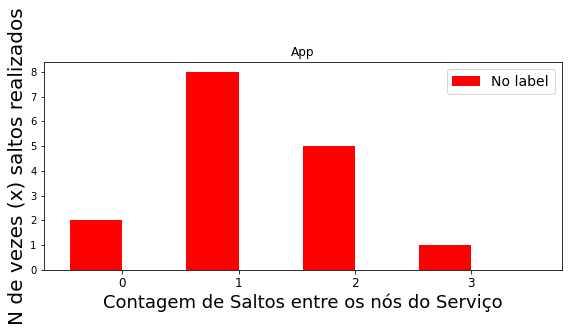

In [34]:
fig, ax = plt.subplots(figsize=(8.0,4.0))
ax.get_xaxis().set_ticks(range(0, len(ticks) * 2, 2))
r = ax.bar(ind, data_a, width, color='r')
ax.set_xticks(ind+ width/2)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_title("App")
ax.set_xlim(-width, len(ticks))
ax.plot([], c='#a6bddb', label="No LABEL",linewidth=3)
ax.set_xlabel("Contagem de Saltos entre os nós do Serviço", fontsize=18)
ax.set_ylabel("N de vezes (x) saltos realizados", fontsize=20)
plt.legend([r],['No label'],loc="upper right",fontsize=14)
plt.tight_layout()
#fazer a contagem de saltos agregada pela média e pelo tempo de simulação

In [35]:
y = sum(cache_distance.values())
print(y)

21


In [36]:
z = len(cache_distance.keys())
print(z)

16


In [37]:
avg_hop = y/z
print(f"Média de saltos no cenário = {avg_hop}")

Média de saltos no cenário = 1.3125


In [38]:
df_link = pd.read_csv('sim_trace_link.csv')

In [39]:
df_link.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       91 non-null     int64  
 1   type     91 non-null     object 
 2   src      91 non-null     int64  
 3   dst      91 non-null     int64  
 4   app      91 non-null     int64  
 5   latency  91 non-null     float64
 6   message  91 non-null     object 
 7   ctime    91 non-null     float64
 8   size     91 non-null     int64  
 9   buffer   91 non-null     int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 7.2+ KB


In [40]:
df_link.head()

,id,type,src,dst,app,latency,message,ctime,size,buffer
0,1,LINK,1,0,0,1.00002,M.USER.APP.0,100.0,20,0
1,2,LINK,2,5,0,1.00002,M.USER.APP.0,100.0,20,1
2,3,LINK,3,13,0,1.00002,M.USER.APP.0,100.0,20,2
3,4,LINK,4,0,0,1.00002,M.USER.APP.0,100.0,20,3
4,5,LINK,5,1,0,1.00002,M.USER.APP.0,100.0,20,4


In [41]:
df_link.tail()

,id,type,src,dst,app,latency,message,ctime,size,buffer
86,72,LINK,2,10,0,1.00002,M.USER.APP.0,1100.0,20,0
87,73,LINK,3,13,0,1.00002,M.USER.APP.0,1100.0,20,1
88,75,LINK,5,1,0,1.00002,M.USER.APP.0,1100.0,20,2
89,76,LINK,6,1,0,1.00002,M.USER.APP.0,1100.0,20,3
90,77,LINK,7,4,0,1.00002,M.USER.APP.0,1100.0,20,4


In [42]:
total_messages = len(df_link)
print(f'total messages transmited = {total_messages}')

total messages transmited = 91


In [43]:
bytes_transmited = df_link["size"].sum()
print(f'total bytes transmited = {bytes_transmited}')

total bytes transmited = 1820


In [44]:
def utilization(id_entity, total_time, from_time=0.0):
        if "time_service" not in df.columns: #cached
            df["time_service"] = df.time_out - df.time_in
        values = df.groupby("DES.dst").time_service.agg("sum")
        return values[id_entity] / total_time

In [45]:
values = df.groupby("DES.dst").time_service.agg("sum")

In [46]:
values

DES.dst
8     4.8000
10    1.0000
11    2.1000
12    0.4125
13    0.9000
Name: time_service, dtype: float64

# Tempo de resposta do APP

In [47]:
def getRbyApp(df,dtmp):
    dr = pd.DataFrame(
        columns=['app', 'user', 'avg', 'std', 'm', 'r', 'invalid', 'over','totalmsg'])  # m - numero de mensagens enviadas
    times = []
    ixloc = 0
    for g in dtmp.keys():
        ids = dtmp[g]
        responses = []
        messages = []
        over = 0
        # Firstly, it computes the mode in all the app,user transmissions
        for i in ids:
            messages.append(df[df.id == i].shape[0])  # number of messages send by the user

        # Requests with a inferior number of messages are filtered
        msg = np.array(messages)
        # mode = stats.mode(msg).mode[0]
        mode = stats.mode(msg)[0][0]

        # Secondly, if each transmission has the same mode then the time is storaged
        invalid = 0
        for i in ids:
            dm = df[df.id == i]
            if mode == dm.shape[0]:
                r = dm['time_out'].max() - dm['time_emit'].min()
                responses.append(r)
                times.append(dm['time_emit'].min())
            else:
                invalid += 1

        resp = np.array(responses)

        avg = resp.mean()
        dsv = resp.std()
        totalmsg = len(resp)
        dr.loc[ixloc] = [g[0], g[1], avg, dsv, mode, resp, invalid, over,totalmsg]
        ixloc += 1
        print (g, "\t", len(dtmp[g]), "\t", invalid, "\t", over)

    return dr, times

In [48]:
dtmp = df[df["module.src"]=="None"].groupby(['app','TOPO.src'])['id'].apply(list)